In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from numpy import random
from numpy import log as log
import copy
from scipy.interpolate import make_interp_spline
from PSD import Sx,Sxy
import time

# Injected PSD and CSD

In [2]:
DAY = 86400

In [3]:
Tobs = 10*DAY
df = 1/Tobs
dt = 0.5
fmax = 1/(2*dt)

freq = np.arange(0, fmax+0.1*df, df)

freq.shape, Tobs/dt, fmax, freq[0], freq[-1]

((864001,), 1728000.0, 1.0, np.float64(0.0), np.float64(1.0))

In [4]:
psdx0 = Sx(freq, SA=1e-30, SP=1e-24)
psdxy = Sxy(freq, SA=1e-30, SP=1e-24)

In [5]:
# the 0th element of psdx0&psdxy is 0.0
# in case the nan value caused by dividing by 0.0, artificially set:
psdx0[0]=psdx0[1]
psdxy[0]=psdxy[1]
# It's not influential, since we only consider frequency domain >10^-4Hz

In [6]:
# add some disturb to psdx in low frequency domain
freqlog = np.logspace(0,-6,len(freq))
disturb = 2e-46*(-3*np.sin(8*np.pi*freqlog)-0.5*np.cos(4*freqlog+90)**2+0.2*np.cos(freq)+0.5*np.sin(30*freqlog))
disturb[-300000:-1]=0

psdx = psdx0+disturb

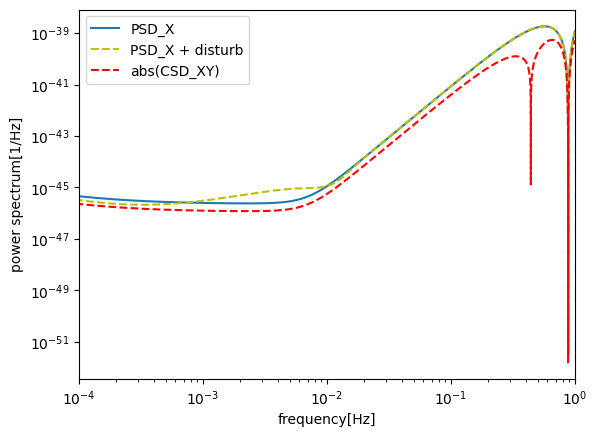

In [7]:
# plt.figure(dpi=300)
plt.loglog(freq, psdx0, label='PSD_X')
plt.loglog(freq, psdx, '--y',label='PSD_X + disturb')
plt.loglog(freq, np.abs(psdxy), '--r',label='abs(CSD_XY)')
plt.xlim(1e-4,1)
# plt.ylim(1e-37,1e-26)
plt.xlabel('frequency[Hz]')
plt.ylabel('power spectrum[1/Hz]')
plt.legend()
plt.show()
# plt.savefig('figs/analy.png')

# PSDfit

In [8]:
# read time domain data
datat = np.load('TQ_XYZ_t.npy')

In [9]:
t = datat[:,0]
Xf = np.fft.rfft(datat[:,1])
Yf = np.fft.rfft(datat[:,2])
freq = np.arange(0, fmax+0.1*df, df)
dt = t[1]-t[0]
N = datat.shape[0]
Tobs = N*dt
df = 1/Tobs
Nf = len(Xf)

In [10]:
PSX = (Xf*np.conjugate(Xf)).real
PSY = (Yf*np.conjugate(Yf)).real
PSXY = (Xf*np.conjugate(Yf)).real

In [11]:
PSXI = (Xf*np.conjugate(Xf)).imag #zero
PSYI = (Yf*np.conjugate(Yf)).imag #zero
PSXYI = (Xf*np.conjugate(Yf)).imag

# initial PSD&CSD

In [12]:
# median average, get initial smooth specturm
def initPSD(PSD):
    Smooth = np.copy(PSD)
    S = np.copy(PSD)
    Dfmax = 128.0*df
    Df2 = Dfmax/2.0
    Df1 = Dfmax/4.0
    end1 = 512
    end2 = 2*end1
    mw = (int)(Dfmax/df)+1  # size of median window
    k = (mw+1)/2
    end3 = int(N/2-k)
    
    mw = int(Df1/df)+1
    k = int((mw+1)/2)
    for i in range(4, k):
        mm = int(i/2)
        kk = int((mm+1)/2)
        Smooth[i] = np.median(S[i-kk:i-kk+mm])/np.log(2)
        
    for i in range(k, end1):
        Smooth[i] = np.median(S[i-k:i-k+mw])/np.log(2)

    mw = int(Df1/df)+1
    k = int((mw+1)/2)
    for i in range(end1, end2):
        Smooth[i] = np.median(S[i-k:i-k+mw])/np.log(2)
    
    mw = int(Dfmax/df)+1
    k = int((mw+1)/2)
    for i in range(end2, end3):
        Smooth[i] = np.median(S[i-k:i-k+mw])/np.log(2)
        
    end4 = int(N/2-4)
    for i in range(end3, end4):
        mm = int((N/2-i)/2)
        kk = int((mm+1)/2)
        Smooth[i] = np.median(S[i-kk:i-kk+mm])/np.log(2)
            
    return Smooth

In [13]:
Smoothx_ini2 = initPSD(PSX)*2*df
Smoothxy_ini2 = initPSD(PSXY)*2*df*np.sqrt(2)  # here we use the real part to approximately recover the CSD, which differ by a factor of √2
                                               # we do not fit image part because it oscillates back and forth around zero, can not be fit by a smooth curve phenomenologically

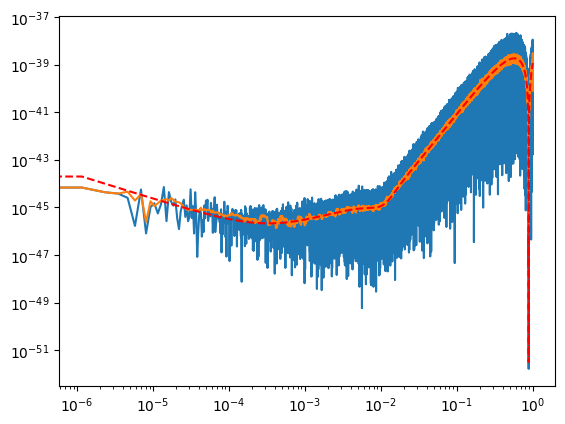

In [14]:
plt.loglog(freq,PSX*2*df)
plt.loglog(freq,Smoothx_ini2)
plt.loglog(freq,psdx,'--r')

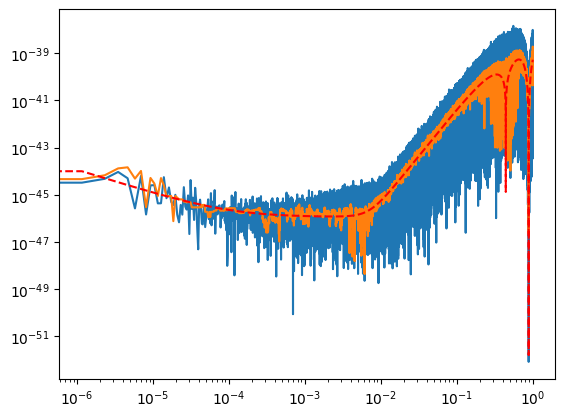

In [15]:
plt.loglog(freq,np.abs(PSXY*2*df))
plt.loglog(freq,np.abs(Smoothxy_ini2))
plt.loglog(freq,np.abs(psdxy),'--r')

In [16]:
# log transform
def symlog_transform(y, linthresh=0.1):
    absy = np.abs(y)
    signy = np.sign(y)
    return np.where(absy > linthresh, 
                    signy * np.log10(absy/ linthresh) * linthresh, 
                    y)

def symlog_inv_transform(ytrans, linthresh=0.1):
    absyt = np.abs(ytrans)
    signy = np.sign(ytrans)
    return np.where(absyt > linthresh, 
                    signy * linthresh * 10**(absyt / linthresh), 
                    ytrans)

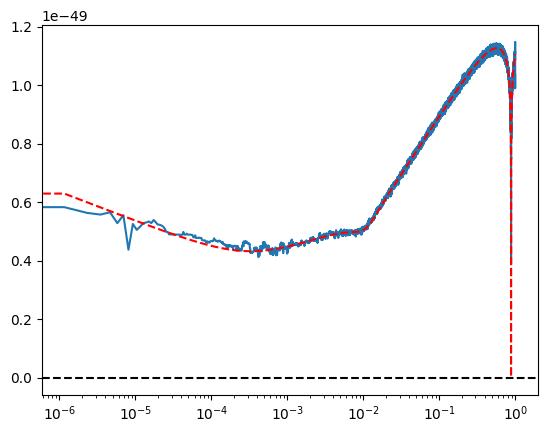

In [17]:
Smoothxtrans = symlog_transform(Smoothx_ini2, linthresh=1e-50)
psdxtrans = symlog_transform(psdx, linthresh=1e-50)

plt.axhline(0, ls='--', color='k')
plt.plot(freq, Smoothxtrans)
plt.plot(freq, psdxtrans, '--',color='r')
plt.xscale('log')

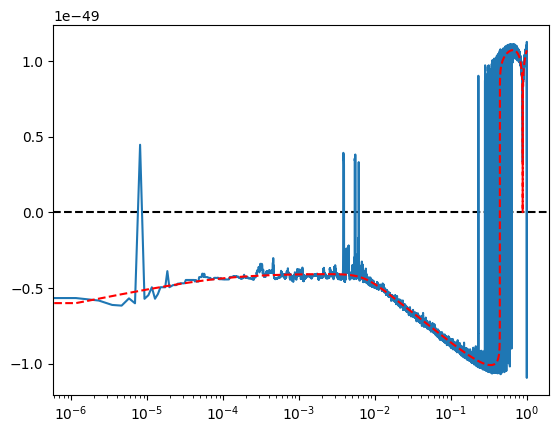

In [18]:
Smoothxytrans = symlog_transform(Smoothxy_ini2, linthresh=1e-50)
psdxytrans = symlog_transform(psdxy, linthresh=1e-50)

plt.axhline(0, ls='--', color='k')
plt.plot(freq, Smoothxytrans)
plt.plot(freq, psdxytrans, '--',color='r')
plt.xscale('log')

In [19]:
# index of 0.2Hz
cut = np.where(freq>0.2)[0][0]

In [20]:
# index of the second zero point
indpeak2 = np.where(np.abs(Smoothxtrans[cut:])==min(np.abs(Smoothxtrans[cut:])))[0][-1]+cut

In [21]:
# indexs of the first cross-zero point of CSD
indx1 = np.where(freq>0.2)[0]
indx2 = np.where(freq<0.8)[0]
indpeak1 = []
for i in range(indx1[0],indx2[-1]):
    if Smoothxytrans[i]/Smoothxytrans[i-1] < 0:
        indpeak1.append(i)

In [22]:
# choose points as initial interpolation knots for PSD
# low frequency domain: logarithmic sampling
# high frequency domain: piecewise linear sampling
# To better recover features near the zero point, the sampling is denser in that segment

logpoint1 = np.logspace(0,math.log10(cut),25)

xlist = [int(logpoint1[0])]

for i in range(1,len(logpoint1)):
    if int(logpoint1[i]) != int(logpoint1[i-1]):
        xlist.append(int(logpoint1[i]))
        
linearpoint1 = np.linspace(cut, indpeak2-40000, 7)
for i in range(len(linearpoint1)):
    xlist.append(int(linearpoint1[i]))
    
linearpoint3 = np.linspace(indpeak2-40000, indpeak2+40000, 8)
for i in range(len(linearpoint3)):
    xlist.append(int(linearpoint3[i]))

linearpoint4 = np.linspace(indpeak2+20000, len(freq)-30, 3)
for i in range(len(linearpoint4)):
    xlist.append(int(linearpoint4[i]))

In [23]:
# sample points from log-tranformed initial smooth spectrum, and interpolate
Ysplinex_ini0 = Smoothxtrans[xlist]
ffitx_ini0 = freq[xlist]
# Sorting ensures that the abscissa is monotonically increasing
sort_idx = np.argsort(ffitx_ini0)
ffitx_sort = ffitx_ini0[sort_idx]
Ysplinex_sort = Ysplinex_ini0[sort_idx]
# Remove duplicate values
ffitx_ini, idx_unique = np.unique(ffitx_sort, return_index=True)
Ysplinex_ini = Ysplinex_sort[idx_unique]

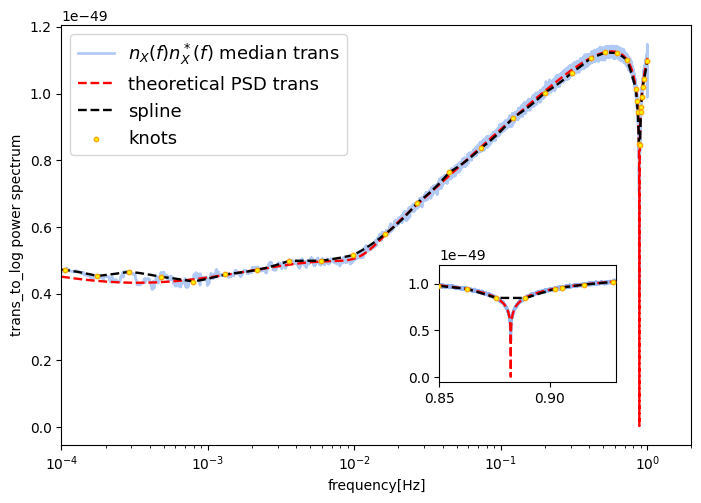

In [24]:
# initial interpolation
knotsplinex = make_interp_spline(ffitx_ini,Ysplinex_ini, 1)(freq)

fig = plt.figure(figsize=(9, 6))
ax = fig.add_axes([0.1, 0.18, 0.7, 0.7])

ax.plot(freq, Smoothxtrans,color='cornflowerblue',alpha=0.5,linewidth=2,label='$n_X(f)n_X^*(f)$ median trans')
ax.plot(freq, psdxtrans,'--',color='r',linewidth=1.7,label='theoretical PSD trans')
ax.plot(freq, knotsplinex,'--',linewidth=1.7,color='black',label='spline')
ax.scatter(ffitx_ini, Ysplinex_ini, s=10,facecolors='yellow', edgecolors='orange', zorder=4,label='knots')
ax.set_xscale('log')

axins = ax.inset_axes((0.6, 0.15, 0.28, 0.28))
axins.plot(freq, Smoothxtrans,color='cornflowerblue',alpha=0.7,linewidth=2,label='$n_X(f)n_X^*(f)$ median trans')
axins.plot(freq, psdxtrans,'--',color='r',linewidth=1.7,label='theoretical PSD trans')
axins.plot(freq, knotsplinex,'--',linewidth=1.7,color='black',label='spline')
axins.scatter(ffitx_ini, Ysplinex_ini, s=10,facecolors='yellow', edgecolors='orange', zorder=4,label='knots')
axins.set_xlim(0.85,0.93)

# plt.xscale('log')
ax.set_xlabel('frequency[Hz]')
ax.set_ylabel('trans_to_log power spectrum')
ax.set_xlim(1e-4,2)

plt.rcParams.update({'font.size': 13})
plt.legend(loc='best')
plt.show()

In [25]:
# choose points as initial interpolation knots for CSD
# low frequency domain: logarithmic sampling
# high frequency domain: piecewise linear sampling
# The segments are divided according to the indexs of zero points.

logpoint = np.logspace(0,math.log10(indpeak1[0]-10000),20)

xylist = [int(logpoint[0])]

for i in range(1,len(logpoint)):
    if int(logpoint[i]) != int(logpoint[i-1]):
        xylist.append(int(logpoint[i]))
        
linearpoint = np.linspace(xylist[-1]+1, indpeak1[-1]-1000, 10)
for i in range(len(linearpoint)):
    xylist.append(int(linearpoint[i]))
    
linearpoint2 = np.linspace(indpeak1[-1]-1000, indpeak2-20000, 4)
for i in range(len(linearpoint2)):
    xylist.append(int(linearpoint2[i]))

linearpoint3 = np.linspace(indpeak2-20000, indpeak2+20000, 6)
for i in range(len(linearpoint3)):
    xylist.append(int(linearpoint3[i]))

linearpoint4 = np.linspace(indpeak2+20000, len(freq)-30, 3)
for i in range(len(linearpoint4)):
    xylist.append(int(linearpoint4[i]))

In [26]:
Ysplinexy_ini0 = Smoothxytrans[xylist]
ffitxy_ini0 = freq[xylist]

sort_idxy = np.argsort(ffitxy_ini0)
ffitxy_sort = ffitxy_ini0[sort_idxy]
Ysplinexy_sort = Ysplinexy_ini0[sort_idxy]

ffitxy_ini, idxy_unique = np.unique(ffitxy_sort, return_index=True)
Ysplinexy_ini = Ysplinexy_sort[idxy_unique]

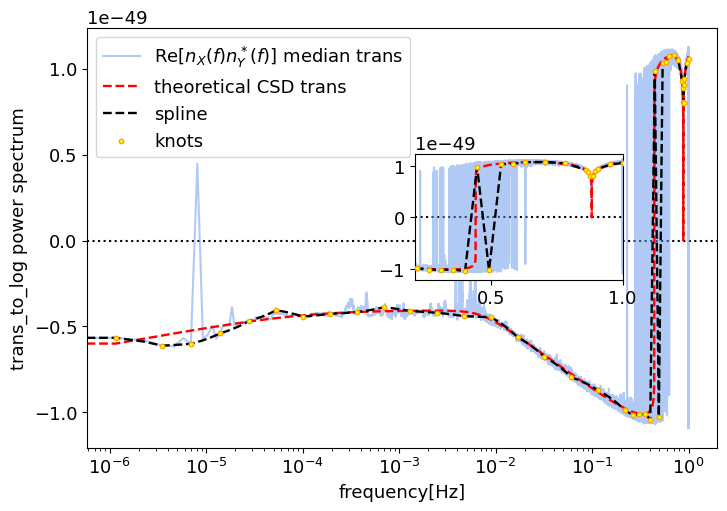

In [27]:
knotsplinexy = make_interp_spline(ffitxy_ini,Ysplinexy_ini,1)(freq)

fig = plt.figure(figsize=(9, 6))
ax = fig.add_axes([0.1, 0.18, 0.7, 0.7])

ax.axhline(0, ls=':', color='k')
ax.plot(freq, Smoothxytrans,color='cornflowerblue',alpha=0.5,label='Re$[n_X(f)n_Y^*(f)]$ median trans')
ax.plot(freq, psdxytrans,'--',color='r',linewidth=1.7,label='theoretical CSD trans')
ax.plot(freq, knotsplinexy,'--',color='black',linewidth=1.7,label='spline')
ax.scatter(ffitxy_ini, Ysplinexy_ini, s=10,facecolors='yellow', edgecolors='orange', zorder=4,label='knots')
ax.set_xscale('log')

axins = ax.inset_axes((0.52, 0.4, 0.33, 0.3))
axins.axhline(0, ls=':', color='k')
axins.plot(freq, Smoothxytrans,color='cornflowerblue',alpha=0.5,label='Re$[n_X(f)n_Y^*(f)]$ median trans')
axins.plot(freq, psdxytrans,'--',color='r',linewidth=1.7,label='theoretical CSD trans')
axins.plot(freq, knotsplinexy,'--',color='black',linewidth=1.7,label='spline')
axins.scatter(ffitxy_ini, Ysplinexy_ini, s=10,facecolors='yellow', edgecolors='orange', zorder=4,label='knots')
axins.set_xlim(0.21,1.0)

ax.set_xlabel('frequency[Hz]')
ax.set_ylabel('trans_to_log power spectrum')

plt.rcParams.update({'font.size': 13})
plt.legend(loc='upper left')
plt.show()

In [28]:
Nsplinex_ini = len(ffitx_ini)
Nsplinexy_ini = len(ffitxy_ini)

In [29]:
# index where interpolation is replaced by trigonometric function
peak_ind = [int(indpeak1[0]-1000), int(indpeak1[-1]+1000), int(indpeak2-5000), int(indpeak2+5000)]

In [30]:
# trigonometric function
def analysiz_psd_x(freq, A,B,C,fstar=3/1.7):
    ss = A*freq**2 + B *freq + C
    ss *= np.sin(2*np.pi*freq/fstar)**2 * freq
    return ss

def analysiz_psd_xy(freq, A,B,C,fstar=3/1.7):
    ss = A*freq**2 + B *freq + C
    ss *= np.sin(2*np.pi*freq/fstar)**2 * np.cos(2*np.pi*freq / fstar) * 2*freq
    return ss

In [31]:
SMx_ini0 = symlog_inv_transform(knotsplinex, linthresh=1e-50)
SMxy_ini0 = symlog_inv_transform(knotsplinexy, linthresh=1e-50)

(-1e-41, 1e-41)

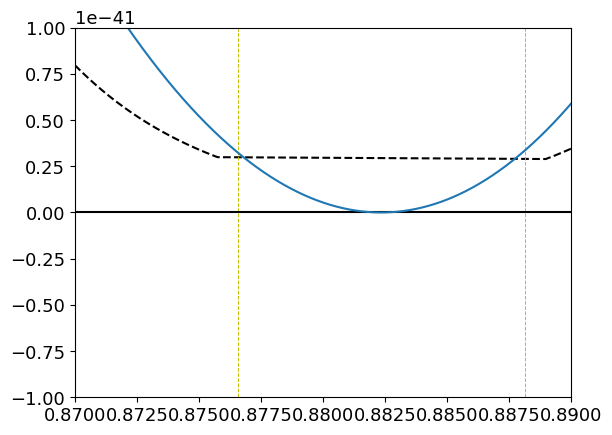

In [32]:
# (initial values are roughly determined by the magnitude of the data)
Ax_ini = 5.0e-39
Bx_ini = 5.0e-39
Cx_ini = 5.0e-40
analx_ini = analysiz_psd_x(freq, Ax_ini, Bx_ini, Cx_ini)

plt.plot(freq,(SMx_ini0),'--',color='black')
plt.axvline(freq[peak_ind[2]],color='y',linewidth=0.7,linestyle='--')
plt.axvline(freq[peak_ind[3]],color='y',linewidth=0.7,linestyle='--')
plt.axhline(0.0,color='black')
plt.plot(freq,(analx_ini))
plt.xlim(0.87,0.89)
plt.ylim(-1e-41,1e-41)

In [33]:
# difference of the connection points between initial analytical part and interpolation part
# if it's smaller than 0.2, we adopt this initial state
print((analx_ini[peak_ind[2]]-SMx_ini0[peak_ind[2]])/SMx_ini0[peak_ind[2]])
print((analx_ini[peak_ind[3]]-SMx_ini0[peak_ind[3]])/SMx_ini0[peak_ind[3]])

0.08161009081224714
0.1629746054149667


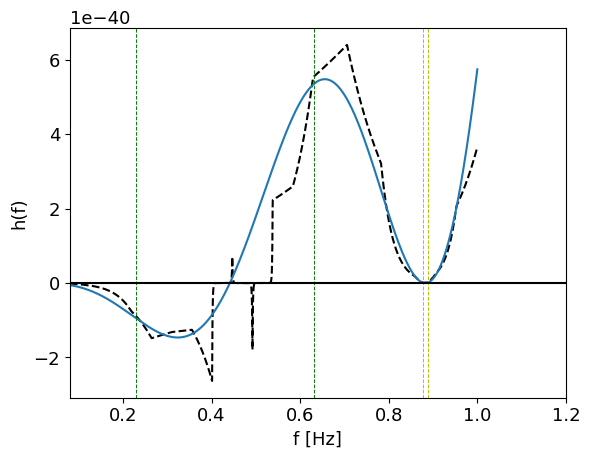

In [34]:
Axy_ini = -1e-39
Bxy_ini = -5e-40
Cxy_ini = -4e-40
analxy_ini = analysiz_psd_xy(freq, Axy_ini, Bxy_ini, Cxy_ini)

plt.plot(freq,(SMxy_ini0),'--',color='black')
plt.plot(freq,(analxy_ini),label='$h(f)_{CSD}$ initial')
plt.axvline(freq[peak_ind[0]],color='g',linewidth=0.7,linestyle='--')
plt.axvline(freq[peak_ind[1]],color='g',linewidth=0.7,linestyle='--')
plt.axvline(freq[peak_ind[2]],color='y',linewidth=0.7,linestyle='--')
plt.axvline(freq[peak_ind[3]],color='y',linewidth=0.7,linestyle='--')
plt.axhline(0.0,color='black')
plt.xlim(0.08,1.2)
# plt.xlim(0.87,0.89)
# plt.ylim(-1e-41,1e-41)
plt.xlabel('f [Hz]')
plt.ylabel('h(f)')
plt.show()

In [35]:
print((analxy_ini[peak_ind[0]]-SMxy_ini0[peak_ind[0]])/SMxy_ini0[peak_ind[0]])
print((analxy_ini[peak_ind[1]]-SMxy_ini0[peak_ind[1]])/SMxy_ini0[peak_ind[1]])
print((analxy_ini[peak_ind[2]]-SMxy_ini0[peak_ind[2]])/SMxy_ini0[peak_ind[2]])
print((analxy_ini[peak_ind[3]]-SMxy_ini0[peak_ind[3]])/SMxy_ini0[peak_ind[3]])

0.06884740726133193
-0.03576842503464461
-0.17721688689499238
-0.13325418893028682


In [36]:
# replace

SMx_ini = np.copy(SMx_ini0)
SMx_ini[peak_ind[2]:peak_ind[3]] = analx_ini[peak_ind[2]:peak_ind[3]]

SMxy_ini = np.copy(SMxy_ini0)
SMxy_ini[peak_ind[0]:peak_ind[1]] = analxy_ini[peak_ind[0]:peak_ind[1]]
SMxy_ini[peak_ind[2]:peak_ind[3]] = analxy_ini[peak_ind[2]:peak_ind[3]]

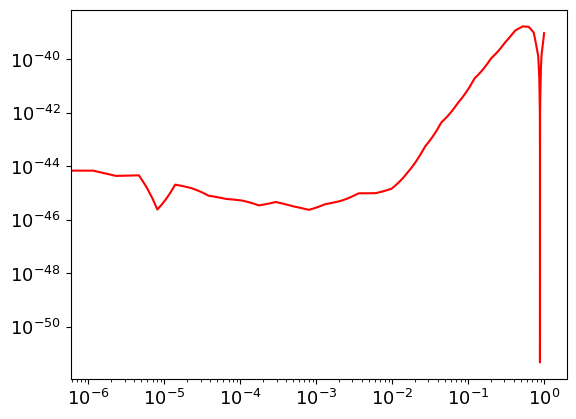

In [37]:
plt.loglog(freq, np.abs(SMx_ini),'r')

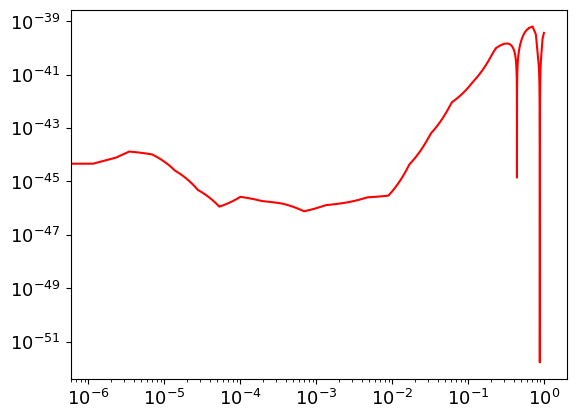

In [38]:
plt.loglog(freq, np.abs(SMxy_ini),'r')

In [40]:
# index of 0.1mHz
lowcut = np.where(freq>1e-4)[0][0]

In [41]:
# initial likelihood
loglikeini0 = -0.5*(((PSX[lowcut:-30]+PSY[lowcut:-30])*SMx_ini[lowcut:-30] - 2*PSXY[lowcut:-30]*SMxy_ini[lowcut:-30])/(SMx_ini[lowcut:-30]**2-SMxy_ini[lowcut:-30]**2)+ log(2*np.pi*np.abs(SMx_ini[lowcut:-30]**2-SMxy_ini[lowcut:-30]**2)))
loglikeini = np.sum(loglikeini0)

# RJMCMC

In [42]:
# points where the "birth" step sample from
birthchoice = np.logspace(-6,0,864000)/df

In [43]:
scale = 1e-55
def updatesmoothx(Nspline, ffit, Yspline, anal):
    control = random.random()
    
    # move
    if control<0.33 or Nspline>60 or Nspline<20:
        k = int(random.random()*(Nspline-1))    # randomly choose a point to update
        Yspline[k] += random.normal(0, scale)
        rjmove = 0
        changeind = k
        
    # birth
    if 0.33<=control<=0.66 and 20<=Nspline<=60:
        k = int(random.choice(birthchoice))
        for j in range(Nspline-1):
            if ffit[j] < freq[k] and ffit[j+1] > freq[k]:   # find the index of new point in ffit
                ffittem = np.insert(ffit,j+1,freq[k])        # insert the new point into the knots
                Ysplinetem = np.insert(Yspline,j+1,Smoothxtrans[k])
                ffit = ffittem
                Yspline = Ysplinetem
                Nspline += 1
        rjmove = 1
        changeind = k

    # death
    if control>0.66 and 20<=Nspline<=60:
        k = int(random.random()*(Nspline-1))      # randomly choose a point to delete
        changeind = np.where(freq==ffit[k])[0][0]
        if k != 0 and k != Nspline and k != Nspline-1:
            ffittem = np.delete(ffit, k)
            Ysplinetem = np.delete(Yspline, k)
            ffit = ffittem
            Yspline = Ysplinetem
            Nspline -= 1
        rjmove = -1

    # interpolate
    lcs = make_interp_spline(ffit,Yspline,1)(freq)
    
    # replace by trigonometric function near zero points
    lcs_semi = symlog_inv_transform(lcs, linthresh=1e-50)
    lcs_semi[peak_ind[2]:peak_ind[3]] = anal[peak_ind[2]:peak_ind[3]]

    return lcs_semi, ffit, Yspline, Nspline, rjmove, changeind


In [44]:
def updatesmoothxy(Nspline, ffit, Yspline, anal):

    control = random.random()
    
    if control<0.33 or Nspline>60 or Nspline<20:
        k = int(random.random()*(Nspline))
        Yspline[k] += random.normal(0, scale)
        rjmove = 0
        changeind = k
        
    if 0.33<=control<=0.66 and 20<=Nspline<=60:
        k = int(random.choice(birthchoice))
        for j in range(Nspline-1):
            if ffit[j] < freq[k] and ffit[j+1] > freq[k]:
                ffittem = np.insert(ffit,j+1,freq[k])
                Ysplinetem = np.insert(Yspline,j+1,Smoothxytrans[k])
                ffit = ffittem
                Yspline = Ysplinetem
                Nspline += 1
        rjmove = 1
        changeind = k

    if control>0.66 and 20<=Nspline<=60:
        k = int(random.random()*(Nspline))
        changeind = np.where(freq==ffit[k])[0][0]
        if k != 0 and k != Nspline and k != Nspline-1:
            ffittem = np.delete(ffit, k)
            Ysplinetem = np.delete(Yspline, k)
            ffit = ffittem
            Yspline = Ysplinetem
            Nspline -= 1
        rjmove = -1


    lcs = make_interp_spline(ffit,Yspline,1)(freq)
    
    lcs_semi = symlog_inv_transform(lcs, linthresh=1e-50)
    lcs_semi[peak_ind[0]:peak_ind[1]] = anal[peak_ind[0]:peak_ind[1]]
    lcs_semi[peak_ind[2]:peak_ind[3]] = anal[peak_ind[2]:peak_ind[3]]
        
    return lcs_semi, ffit, Yspline, Nspline, rjmove, changeind

In [45]:
def loglike(SnX, SnXY):
    loglike0 = -0.5*(((PSX[lowcut:-30]+PSY[lowcut:-30])*SnX[lowcut:-30] - 2*PSXY[lowcut:-30]*SnXY[lowcut:-30])/(SnX[lowcut:-30]**2-SnXY[lowcut:-30]**2) + log(2*np.pi*np.abs(SnX[lowcut:-30]**2-SnXY[lowcut:-30]**2)))
    return np.sum(loglike0)

In [46]:
def rj_psd(Nstep, Ysplinex, ffitx, SMx, SMxy, Ax, Bx, Cx, Nsplinex, loglikeli):
    acc = 0
    for mc in range(Nstep):
        Ax_pro, Bx_pro, Cx_pro = random.normal(Ax, 1e-41), random.normal(Bx, 1e-41), random.normal(Cx, 1e-41)
        analx_pro = analysiz_psd_x(freq, Ax_pro, Bx_pro, Cx_pro)

        SMx_pro, ffitx_pro, Ysplinex_pro, Nsplinex_pro, rjmove, changeind = updatesmoothx(Nsplinex, ffitx, Ysplinex, analx_pro)
        
        loglikeli_pro = loglike(SMx_pro, SMxy)

        if rjmove==-1:
            if np.abs(SMx_pro[changeind]-SMx[changeind])> SMx_ini_sigma[changeind]:
                # print("large change")
                likelist.append(loglikeli)
                continue
        
        connect1 = np.abs((SMx_pro[peak_ind[2]-1]-analx_pro[peak_ind[2]-1])/(SMx_pro[peak_ind[2]-1]))
        connect2 = np.abs((SMx_pro[peak_ind[3]-1]-analx_pro[peak_ind[3]-1])/(SMx_pro[peak_ind[3]-1]))
        if connect1>0.2 or connect2>0.2:
            # print('bad connection')
            likelist.append(loglikeli)
            continue
        
        H = loglikeli_pro - loglikeli
        alpha = log(random.random())
        
        
        # if np.abs(H)<10:
        #     if Nsplinex_pro>Nsplinex:
        #         likelist.append(loglikeli)
        #         continue

        
        if H>alpha:
            loglikeli = loglikeli_pro
            Ysplinex = Ysplinex_pro
            SMx = SMx_pro
            ffitx = ffitx_pro
            Nsplinex = Nsplinex_pro
            
            Ax, Bx, Cx = Ax_pro, Bx_pro, Cx_pro
            
            acc+=1
            
        likelist.append(loglikeli)
    
    return Ysplinex, ffitx, SMx, Ax, Bx, Cx, Nsplinex, likelist
    

In [47]:
def rj_csd(Nstep, Ysplinexy, ffitxy, SMx, SMxy, Axy, Bxy, Cxy, Nsplinexy, loglikeli):
    acc=0
    for mc in range(Nstep):
        Axy_pro, Bxy_pro, Cxy_pro = random.normal(Axy, 1e-42), random.normal(Bxy, 1e-42), random.normal(Cxy, 1e-42)
        analxy_pro = analysiz_psd_xy(freq, Axy_pro, Bxy_pro, Cxy_pro)

        SMxy_pro, ffitxy_pro, Ysplinexy_pro, Nsplinexy_pro, rjmove, changeind = updatesmoothxy(Nsplinexy, ffitxy, Ysplinexy, analxy_pro)
        
        loglikeli_pro = loglike(SMx, SMxy_pro)

        connect1 = np.abs((SMxy_pro[peak_ind[0]-1]-analxy_pro[peak_ind[0]-1])/(SMxy_pro[peak_ind[0]-1]))
        connect2 = np.abs((SMxy_pro[peak_ind[1]-1]-analxy_pro[peak_ind[1]-1])/(SMxy_pro[peak_ind[1]-1]))
        connect3 = np.abs((SMxy_pro[peak_ind[2]-1]-analxy_pro[peak_ind[2]-1])/(SMxy_pro[peak_ind[2]-1]))
        connect4 = np.abs((SMxy_pro[peak_ind[3]-1]-analxy_pro[peak_ind[3]-1])/(SMxy_pro[peak_ind[3]-1]))
        if connect1>0.2 or connect2>0.2 or connect3>0.2 or connect4>0.2:
            likelist.append(loglikeli)
            # print("bad connection")
            continue

        if (rjmove==1 or rjmove==-1):
            if np.abs(SMxy_pro[changeind]-SMxy[changeind])> SMxy_ini_sigma[changeind]:
                likelist.append(loglikeli)
                # print("large change")
                continue

        H = loglikeli_pro - loglikeli
        
        alpha = log(random.random())

        if H>alpha:
            loglikeli = loglikeli_pro
            Ysplinexy = Ysplinexy_pro
            SMxy = SMxy_pro
            ffitxy = ffitxy_pro
            Nsplinexy = Nsplinexy_pro
            
            Axy, Bxy, Cxy = Axy_pro, Bxy_pro, Cxy_pro
            
            acc+=1
            
        likelist.append(loglikeli)

    return Ysplinexy, ffitxy, SMxy, Axy, Bxy, Cxy, Nsplinexy, likelist
    


In [ ]:
SMx_ini_sigma = np.sqrt(2/128)*Smoothx_ini2
SMxy_ini_sigma = np.sqrt(2/128)*Smoothxy_ini2
likelist = [loglikeini]

# gibbs round1
Ysplinex, ffitx, SMx, Ax, Bx, Cx, Nsplinex, likelist = rj_psd(1000, Ysplinex_ini, ffitx_ini, SMx_ini, SMxy_ini, Ax_ini, Bx_ini, Cx_ini, Nsplinex_ini, loglikeini)
Ysplinexy, ffitxy, SMxy, Axy, Bxy, Cxy, Nsplinexy, likelist = rj_csd(1000, Ysplinexy_ini, ffitxy_ini, SMx, SMxy_ini, Axy_ini, Bxy_ini, Cxy_ini, Nsplinexy_ini, likelist[-1])
# gibbs round2
Ysplinex, ffitx, SMx, Ax, Bx, Cx, Nsplinex, likelist = rj_psd(1000, Ysplinex, ffitx, SMx, SMxy, Ax, Bx, Cx, Nsplinex, likelist[-1])
Ysplinexy, ffitxy, SMxy, Axy, Bxy, Cxy, Nsplinexy, likelist = rj_csd(1000, Ysplinexy, ffitxy, SMx, SMxy, Axy, Bxy, Cxy, Nsplinexy, likelist[-1])

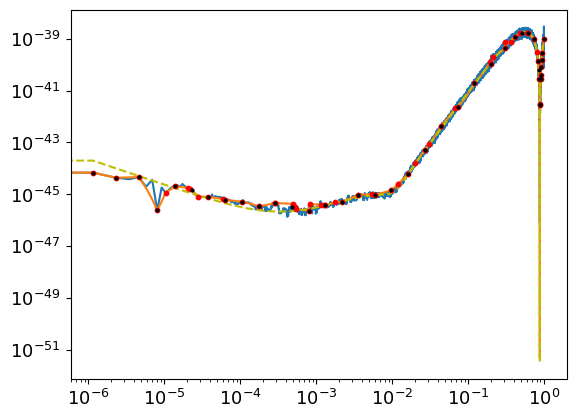

In [49]:
plt.loglog(freq,symlog_inv_transform(Smoothxtrans, linthresh=1e-50))
plt.loglog(freq,abs(SMx))
plt.scatter(ffitx,abs(symlog_inv_transform(Ysplinex, linthresh=1e-50)),s=10,color='r',zorder=3)
plt.scatter(ffitx_ini,abs(symlog_inv_transform(Ysplinex_ini, linthresh=1e-50)),s=4,color='black',zorder=4)
plt.loglog(freq, np.abs(psdx), '--y')

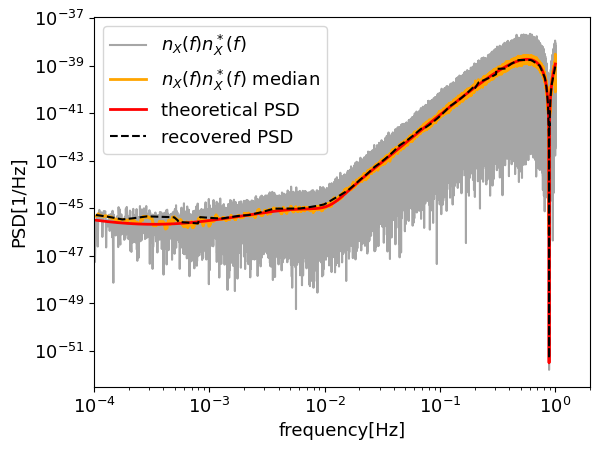

In [50]:
# plt.figure(dpi=300)
plt.rcParams.update({'font.size': 13})
plt.loglog(freq,abs(PSX)*2*df,color='grey',alpha=0.7,label='$n_X(f)n_X^*(f)$')
plt.loglog(freq,abs(Smoothx_ini2),color='orange',alpha=1,linewidth=2,label='$n_X(f)n_X^*(f)$ median')
plt.loglog(freq, np.abs(psdx), '-r', alpha=1,linewidth=2, label='theoretical PSD')
plt.loglog(freq,abs(SMx),color='black',linestyle='--',linewidth=1.5, label='recovered PSD')
plt.xlim(1e-4,2)
# plt.ylim(1e-37,2e-25)
plt.xlabel('frequency[Hz]')
plt.ylabel('PSD[1/Hz]')
plt.legend(loc="best")
# plt.savefig('figs/psdx_fit2.png')

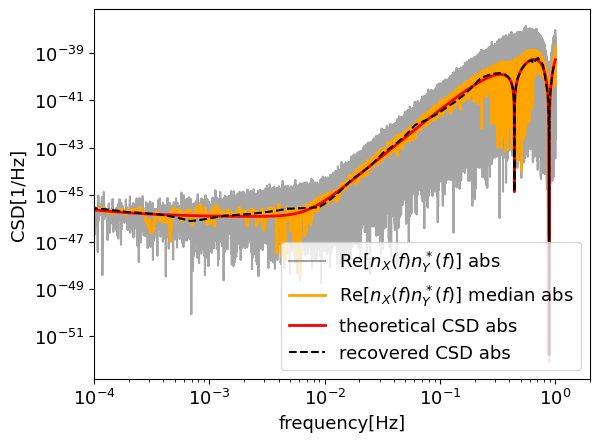

In [51]:
# plt.figure(dpi=300)
plt.rcParams.update({'font.size': 13})
plt.loglog(freq,abs(PSXY)*2*df,color='grey',alpha=0.7,label='Re$[n_X(f)n_Y^*(f)]$ abs')
plt.loglog(freq,abs(Smoothxy_ini2),color='orange',alpha=1,linewidth=2,label='Re$[n_X(f)n_Y^*(f)]$ median abs')
plt.loglog(freq, np.abs(psdxy), '-r', alpha=1,linewidth=2, label='theoretical CSD abs')
plt.loglog(freq,abs(SMxy),color='black',linestyle='--',linewidth=1.5, label='recovered CSD abs')
plt.xlabel('frequency[Hz]')
plt.ylabel('CSD[1/Hz]')
plt.xlim(1e-4,2)
# plt.ylim(1e-38,1e-25)
plt.legend(loc="best")
# plt.savefig('figs/psdxy_fit2.png')

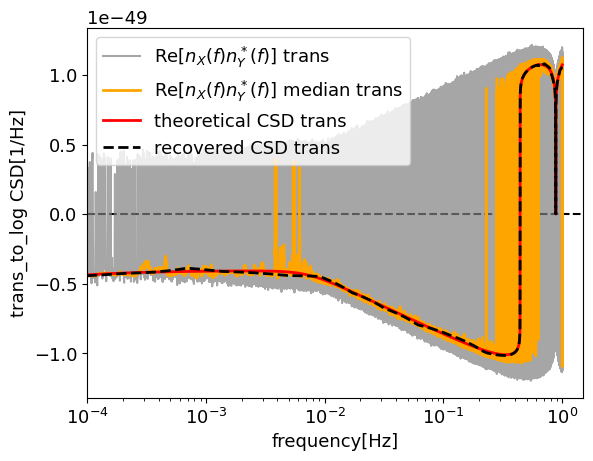

In [52]:
# plt.figure(dpi=300)
plt.rcParams.update({'font.size': 13})
PSXYtrans2 = symlog_transform(PSXY*2*df, linthresh=1e-50)
Smoothxytrans2 = symlog_transform(Smoothxy_ini2, linthresh=1e-50)
psdxytrans2 = symlog_transform(psdxy, linthresh=1e-50)
fittrans2 = symlog_transform(SMxy, linthresh=1e-50)

plt.axhline(0, ls='--', color='k')
plt.plot(freq, PSXYtrans2,color='grey',alpha=0.7,label='Re$[n_X(f)n_Y^*(f)]$ trans')
plt.plot(freq, Smoothxytrans2,color='orange',alpha=1,linewidth=2,label='Re$[n_X(f)n_Y^*(f)]$ median trans')
plt.plot(freq, psdxytrans2, '-',color='r',linewidth=2, label='theoretical CSD trans')
plt.plot(freq, fittrans2, '--',color='black',linewidth=2, label='recovered CSD trans')
plt.xscale('log')
plt.xlim(1e-4,1.5)
plt.xlabel('frequency[Hz]')
plt.ylabel('trans_to_log CSD[1/Hz]')
plt.legend(loc='best')
# plt.savefig('figs/psdxy_fit_trans2.png')

In [53]:
psderr = ((SMx[87:]-psdx[87:])/psdx[87:])
csderr = ((SMxy[87:]-psdxy[87:])/psdxy[87:])

In [54]:
Nlen = len(SMx[87:])
np.sum(np.abs((SMx[87:]-psdx[87:])/psdx[87:]))/Nlen

np.float64(0.09331112597036995)

In [55]:
np.sum(np.abs((SMxy[87:]-psdxy[87:])/psdxy[87:]))/Nlen

np.float64(0.15078112013938513)

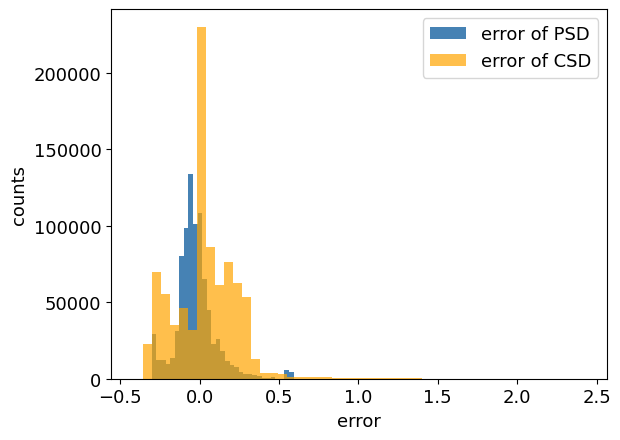

In [56]:
# plt.figure(figsize=(9, 6),dpi=200)
plt.hist(x = psderr,
         bins = 50,
         color = 'steelblue',
         label='error of PSD',
#          range=(0,0.6)
         )
plt.hist(x = csderr,
         bins = 50,
         color = 'orange',
         label='error of CSD',
#          range=(0,0.6),
         alpha=0.7
         )

plt.xlabel('error')
plt.ylabel('counts')

plt.legend()
# plt.savefig('figs/error.png')

# compare with "specfit"

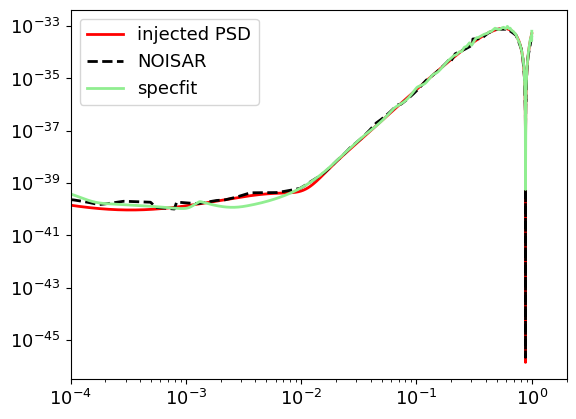

In [67]:
# ! ./SpecFit XYZ_seg0_t2.dat 0

Nt=Tobs/dt
fac=Tobs/Nt/Nt

specfitX = pd.read_csv('specfit.dat', sep=' ', dtype=float, names=['f','SM','SL','SM+SL'])
freq2 = specfitX['f']
SMx2 = specfitX['SM']

plt.loglog(freq,psdx/2/df,color='r',linewidth=2,label="injected PSD")
plt.loglog(freq, SMx/2/df,'--',color="black",linewidth=2,label='NOISAR')
plt.loglog(freq2, SMx2/fac,linewidth=2,color="lightgreen",label='specfit')
plt.xlim(1e-4,2)
plt.legend(loc='best')
plt.show()